In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

import torch
from torch import nn
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
# from torchvision.models import resnet18, ResNet18_Weights

In [3]:
emotions = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

def load_data(usage):
    
    data = []
    value_counts = {}
    
    if usage != 'test' and usage != 'train':
        print(f'Invalid text: \'{usage}\'')
        return [], [], {}

    for emotion in emotions:
        value_counts[emotion] = 0
        
    path = f'/kaggle/input/fer2013pluscleanedaugmballanced1/{usage}'
    print(f'Loading {usage} images... ', end='')
    for class_ in emotions:
        classpath = os.path.join(path, class_)
        for file in os.listdir(classpath):
            filepath = os.path.join(classpath, file)
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            data.append([img, emotions.index(class_)])
            value_counts[class_] += 1
    print('Done!')
    print(f'Loaded {len(data)} images.')
    print()
    
    
    print('Shuffling the data... ', end='')
    random.shuffle(data)
    print('Done!')
    print()
    
    
    print('Splitting and reshaping the data... ', end='')
    X = []
    y = []
    for img, label in data:
        X.append(img)
        y.append(label)
    X = np.array(X) / 255
    y = np.array(y)
    print('Done!')
    print()
    
    return X, y, value_counts

In [4]:
class FERPlus(Dataset):
    def __init__(self, usage='', transform=None):
        self.X, self.y, self.value_counts = load_data(usage)
        self.transform = transform
        self.n_items = self.X.shape[0]
        
    def __len__(self):
        return self.n_items
    
    def __getitem__(self, idx):
        sample = self.X[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, self.y[idx]
    
    def get_weights(self):
        weights = []
        for count in self.value_counts.values():
            weight = self.n_items / (count * 7)
            weights.append(weight)
        return weights

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

In [6]:
training_data = FERPlus(usage='train', transform=transform)
test_data = FERPlus(usage='test', transform=transform)

Loading train images... Done!
Loaded 23251 images.

Shuffling the data... Done!

Splitting and reshaping the data... Done!

Loading test images... Done!
Loaded 5772 images.

Shuffling the data... Done!

Splitting and reshaping the data... Done!



In [7]:
training_data[0][0][0][0][0].dtype

torch.float32

In [8]:
training_data[0][0].shape

torch.Size([1, 48, 48])

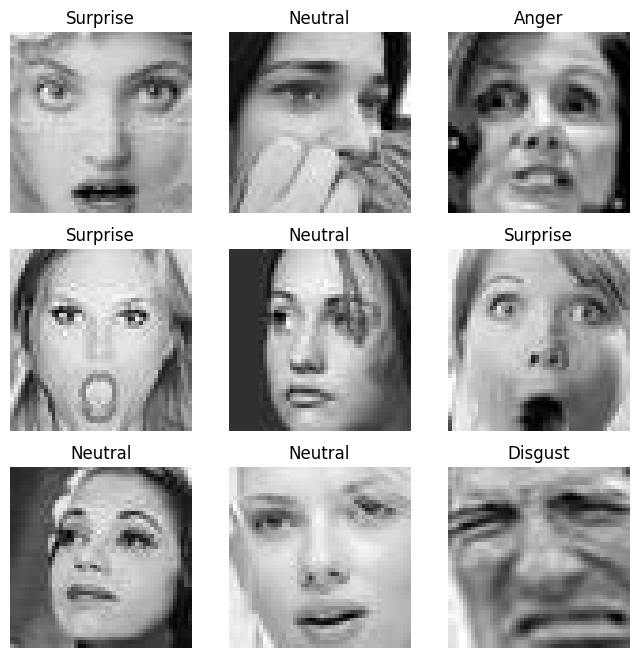

In [9]:
figure = plt.figure(figsize=(8, 8))
rows, cols = 3, 3

for i in range(1, rows*cols + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(emotions[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

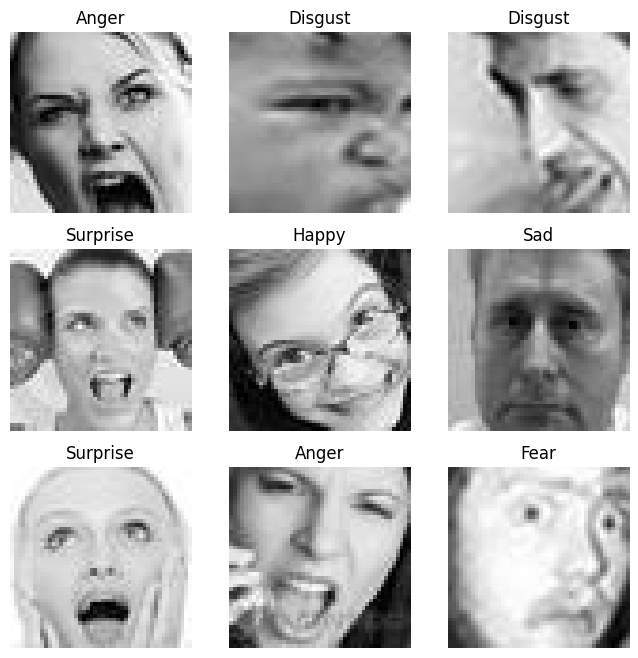

In [10]:
figure = plt.figure(figsize=(8, 8))
rows, cols = 3, 3

for i in range(1, rows*cols + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(emotions[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [13]:
training_data.value_counts

{'Anger': 3315,
 'Disgust': 3367,
 'Fear': 3346,
 'Happy': 3334,
 'Neutral': 3376,
 'Sad': 3192,
 'Surprise': 3321}

In [14]:
batch_size = 32

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [15]:
for X, y in train_dataloader:
    print(f'Shape of X (N, C, H, W): {X.shape}')
    print(f'Shape of y: {y.shape}')
    break

Shape of X (N, C, H, W): torch.Size([32, 1, 48, 48])
Shape of y: torch.Size([32])


In [25]:
class VGG13Custom(nn.Module):
    
    def __init__(self):
        
        super(VGG13Custom, self).__init__()
        
        self.conv3_64 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )

        self.conv3_128 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )

        self.conv3_256_1 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )

        self.conv3_256_2 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )

        self.flatten = nn.Flatten()
        
        # Get the output shape of the flatten layer
        x = torch.randn(1, 1, 48, 48)  # assuming input size (1, 64, 64)
        x = self.conv3_64(x)
        x = self.conv3_128(x)
        x = self.conv3_256_1(x)
        x = self.conv3_256_2(x)
        x = self.flatten(x)

        self.fc = nn.Sequential(
            nn.Linear(x.shape[1], 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 7)
        )
        
    def forward(self, x):
        x = self.conv3_64(x)
        x = self.conv3_128(x)
        x = self.conv3_256_1(x)
        x = self.conv3_256_2(x)
        x = self.fc(self.flatten(x))
        
        return x

In [26]:
device = ('cuda'
         if torch.cuda.is_available
         else 'cpu')
print(f'Using {device} device')

Using cuda device


In [27]:
model = VGG13Custom().to(device)
print(model)

VGG13Custom(
  (conv3_64): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
  )
  (conv3_128): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

In [28]:
# model = resnet18(weights=ResNet18_Weights)

In [29]:
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model.fc = nn.Linear(in_features=512, out_features=8, bias=True)
# model = model.to(device)
# print(model)

In [30]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ''
        
    def __call__(self, model, test_loss):
        if self.best_loss == None:
            self.best_loss = test_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - test_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = test_loss
            self.counter = 0
            self.status = f'Improvement found!'
        elif self.best_loss - test_loss < self.min_delta:
            self.counter += 1
            self.status = f'No improvement in the last {self.counter} epochs.'
            if self.counter >= self.patience:
                self.status = f'Early stopping triggered after {self.counter} epochs.'
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

In [31]:
# weights = torch.tensor(train_data.get_weights()).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, verbose=True, min_lr=0.0001)

In [32]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    training_loss, correct = 0, 0
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        training_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    training_loss /= num_batches
    correct /= size
    return training_loss, correct*100



def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_fn(pred, y)
            
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
    test_loss /= num_batches
    correct /= size
    return test_loss, correct*100

In [33]:
epochs = 0
es = EarlyStopping()
done = False

train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

while epochs < 1000 and not done:
    print(f'Epoch {epochs + 1}: -----------------------------------')
    epochs += 1
    train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f"Train: \n Accuracy: {(train_accuracy):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    
    test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    print(f"Test: \n Accuracy: {(test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    if es(model, test_loss): done = True
    print(es.status)
#     scheduler.step(test_loss)

Epoch 1: -----------------------------------
loss: 1.998173  [   32/23251]
loss: 1.955827  [ 3232/23251]
loss: 1.865375  [ 6432/23251]
loss: 1.990300  [ 9632/23251]
loss: 1.854390  [12832/23251]
loss: 1.836551  [16032/23251]
loss: 1.651425  [19232/23251]
loss: 1.687664  [22432/23251]
Train: 
 Accuracy: 22.8%, Avg loss: 1.797863 

Test: 
 Accuracy: 27.7%, Avg loss: 1.604332 


Epoch 2: -----------------------------------
loss: 1.638685  [   32/23251]
loss: 1.677357  [ 3232/23251]
loss: 1.692234  [ 6432/23251]
loss: 1.519264  [ 9632/23251]
loss: 1.685960  [12832/23251]
loss: 1.925425  [16032/23251]
loss: 1.369066  [19232/23251]
loss: 1.557388  [22432/23251]
Train: 
 Accuracy: 26.9%, Avg loss: 1.617221 

Test: 
 Accuracy: 25.0%, Avg loss: 1.572569 

Improvement found!
Epoch 3: -----------------------------------
loss: 1.732397  [   32/23251]
loss: 1.657523  [ 3232/23251]
loss: 1.527274  [ 6432/23251]
loss: 1.664791  [ 9632/23251]
loss: 1.547378  [12832/23251]
loss: 1.557656  [16032/23251]

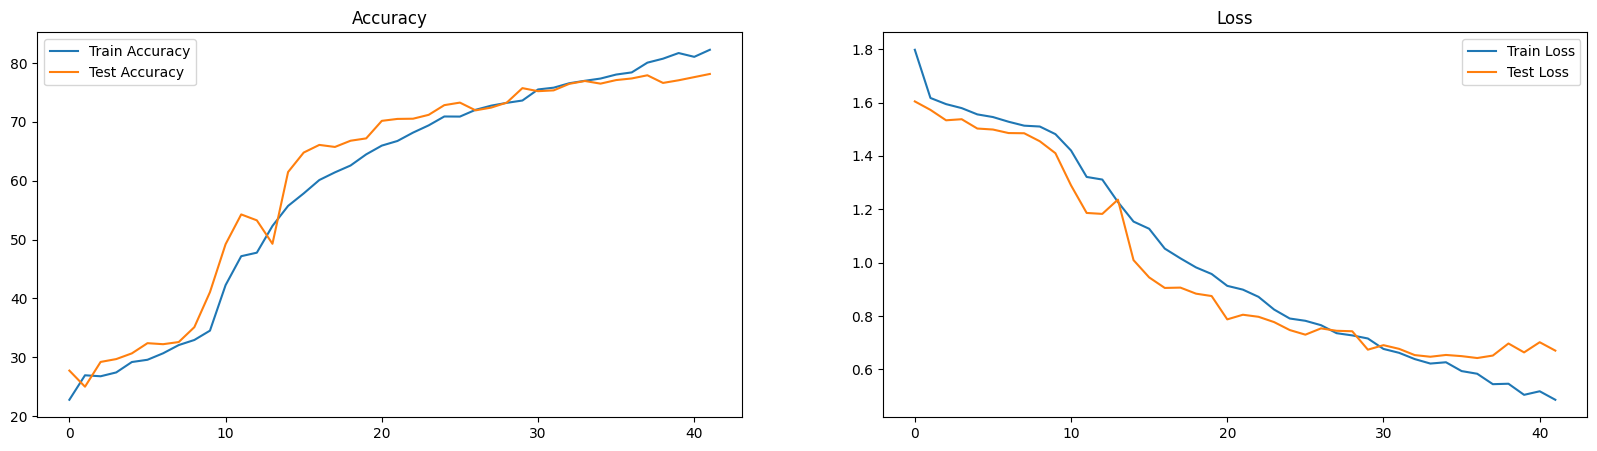

In [34]:
_, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title('Accuracy')
ax[0].plot(range(epochs), train_accuracies, label='Train Accuracy')
ax[0].plot(range(epochs), test_accuracies, label='Test Accuracy')
ax[0].legend()

ax[1].set_title('Loss')
ax[1].plot(range(epochs), train_losses, label='Train Loss')
ax[1].plot(range(epochs), test_losses, label='Test Loss')
ax[1].legend()

plt.show()

In [35]:
model.load_state_dict(es.best_model)

<All keys matched successfully>

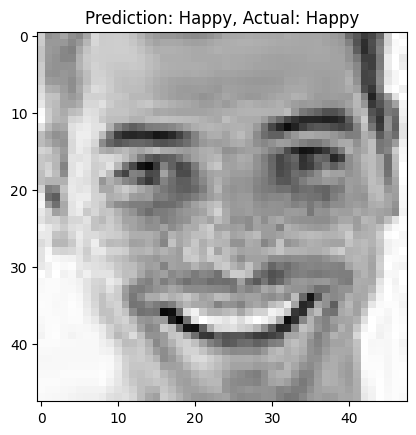

In [43]:
random_idx = torch.randint(len(test_data), size=(1,)).item()
X = test_data[random_idx][0].unsqueeze(0).to(device)
y = test_data[random_idx][1].item()
model.eval()
prediction = model(X)
label = prediction.argmax(1).item()
plt.title(f'Prediction: {emotions[label]}, Actual: {emotions[y]}')
plt.imshow(X.cpu().squeeze(), cmap='gray')
plt.show()

In [44]:
torch.save(model.state_dict(), 'model_weights.pth')
print(f'Saved model state to \'model_weights.pth\'')

Saved model state to 'model_weights.pth'


In [69]:
img = cv2.imread('/kaggle/input/sampleimages/sample5.jpg', cv2.IMREAD_GRAYSCALE)
img = img / 255
X = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(torch.float32).to(device)
X.shape

torch.Size([1, 1, 48, 48])

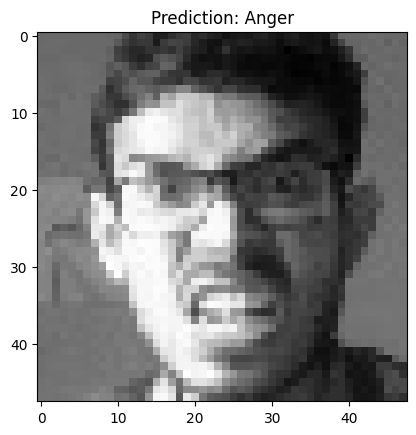

In [70]:
model.eval()
prediction = model(X)
label = prediction.argmax(1).item()
plt.title(f'Prediction: {emotions[label]}')
plt.imshow(X.cpu().squeeze(), cmap='gray')
plt.show()